In [1]:
import GetOldTweets3 as got
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,timedelta
from sklearn.cluster import DBSCAN,KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score,confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle

/Users/macchan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/macchan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/macchan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/macchan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/macchan/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: nump

In [2]:
today = date.today()
yesterday = today - timedelta(days = 1)

In [3]:
df = pd.read_csv('./data/kcbsamfmtraffic.csv')

In [4]:
block = ['block','crash','debris','crawl','jammed','emergency','accident','closed']

def classify(x):
    return bool([word for word in block if(word in x.lower())])

df['class'] = df['tweet'].astype(str).map(classify)
df['class'].value_counts(normalize=True)

True     0.5984
False    0.4016
Name: class, dtype: float64

In [5]:
#df.to_csv('./data/kcbsamfmtraffic_labeled.csv',index=False)

In [5]:
df.dropna(inplace=True)
X = df['tweet']
y = df['class']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=123)

# Logistic Regression

In [6]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer(stop_words='english')),
    ('lr',LogisticRegression())
])

params = {
    'tvec__max_features':[500],
    'tvec__min_df':[100,150,200],
    'tvec__max_df':[.9],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__use_idf':[False,True]
}

gs = GridSearchCV(pipe,params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [7]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 500,
 'tvec__min_df': 100,
 'tvec__ngram_range': (1, 2),
 'tvec__use_idf': True}

In [8]:
print(f'Train score: {gs.best_score_} ')
print(f'Test score: {gs.best_estimator_.score(X_test,y_test)}')

Train score: 0.9615804183355584 
Test score: 0.9656


In [10]:
cm = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 482
False positives: 20
False negatives: 23
True positives: 725


In [20]:
725/748

0.9692513368983957

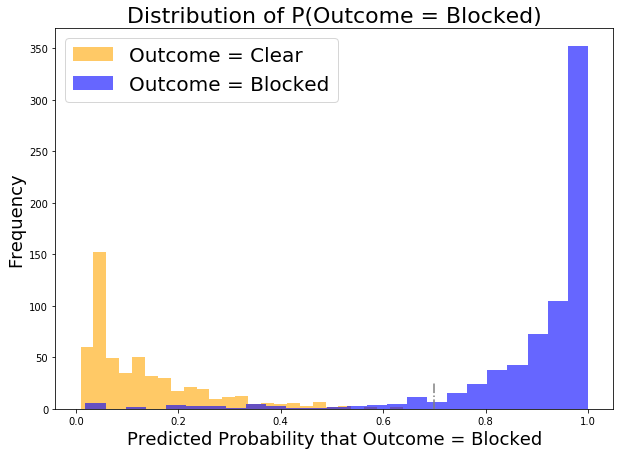

In [28]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))
# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Clear')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Blocked')
plt.vlines(x=.7,
          ymin=0,
          ymax=25,
          color='grey',
          linestyle='dashdot')
# Label axes.
plt.title('Distribution of P(Outcome = Blocked)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Blocked', fontsize = 18)
# Create legend.
plt.legend(fontsize = 20)
#Thank you Matt for the code from our lecture!
plt.savefig('./plots/log_plot.png');

In [29]:
filename = 'predictor.sav'
pickle.dump(gs.best_estimator_, open(filename, 'wb'))

# KNN

In [11]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('knn',KNeighborsClassifier())
])

params = {
    'tvec__max_features':[1000,1500],
    'tvec__min_df':[10,100,150,200],
    'tvec__max_df':[.8],
    'tvec__ngram_range':[(1,1),(1,2)],
    'knn__n_neighbors':[50,100]
}

gs = GridSearchCV(pipe,params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [12]:
gs.best_params_

{'knn__n_neighbors': 50,
 'tvec__max_df': 0.8,
 'tvec__max_features': 1000,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2)}

In [13]:
print(f'Train score: {gs.best_score_} ')
print(f'Test score: {gs.best_estimator_.score(X_test,y_test)}')

Train score: 0.8743394748553627 
Test score: 0.8752


In [14]:
cm = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 396
False positives: 106
False negatives: 50
True positives: 698


In [21]:
698/748

0.9331550802139037

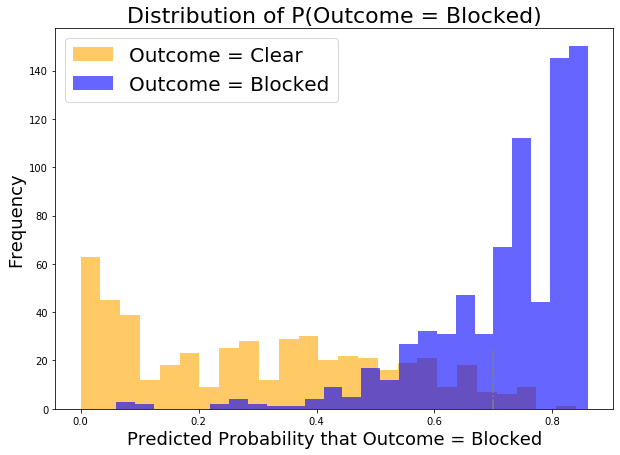

In [15]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
# Create figure.
plt.figure(figsize = (10,7))
# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = Clear')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = Blocked')
plt.vlines(x=.7,
          ymin=0,
          ymax=25,
          color='grey',
          linestyle='dashdot')
# Label axes.
plt.title('Distribution of P(Outcome = Blocked)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Blocked', fontsize = 18)
# Create legend.
plt.legend(fontsize = 20)
#Thank you Matt for the code from our lecture!
plt.savefig('./plots/knn_plot.png');

# SVC

In [16]:
pipe = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('svc',SVC())
])

params = {
    'tvec__max_features':[500,1000,2000],
    'tvec__min_df':[15,50,100,150,200],
    'tvec__max_df':[.8,.9,.7],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__use_idf':[False,True]
}

gs = GridSearchCV(pipe,params,cv=5)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [17]:
gs.best_params_

{'tvec__max_df': 0.8,
 'tvec__max_features': 500,
 'tvec__min_df': 100,
 'tvec__ngram_range': (1, 1),
 'tvec__use_idf': False}

In [18]:
print(f'Train score: {gs.best_score_} ')
print(f'Test score: {gs.best_estimator_.score(X_test,y_test)}')

Train score: 0.9719854027592346 
Test score: 0.9808


In [19]:
cm = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test,
                 gs.best_estimator_.predict(X_test)).ravel()
print(f'True negatives: {tn}')
print(f'False positives: {fp}')
print(f'False negatives: {fn}')
print(f'True positives: {tp}')

True negatives: 501
False positives: 1
False negatives: 23
True positives: 725


In [22]:
725/748

0.9692513368983957